# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## 1 Import packages

In [2]:
import cv2
import os
import glob
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline

## Load Training Data and Shuffling

In [3]:
car1 = glob.glob('vehicles/GTI_Far/*.png')
car2 = glob.glob('vehicles/GTI_Left/*.png')
car3 = glob.glob('vehicles/GTI_Right/*.png')
car4 = glob.glob('vehicles/GTI_MiddleClose/*.png')
car5 = glob.glob('vehicles/KITTI_extracted/*.png')

non_car1 = glob.glob('non-vehicles/Extras/*.png')
non_car2 = glob.glob('non-vehicles/GTI/*.png')

car_paths = car1 + car2 + car3 + car4 + car5
non_car_paths = non_car1 + non_car2

shuffle(car_paths)
shuffle(non_car_paths)

car_imgs = list(map(lambda image: cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB), car_paths))
non_car_imgs = list(map(lambda image: cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB), non_car_paths))

In [4]:
len(car_imgs)

8792

In [5]:
len(non_car_imgs)

8968

In [6]:
car_imgs[0].shape

(64, 64, 3)

In [7]:
non_car_imgs[0].shape

(64, 64, 3)

## Data Exploration

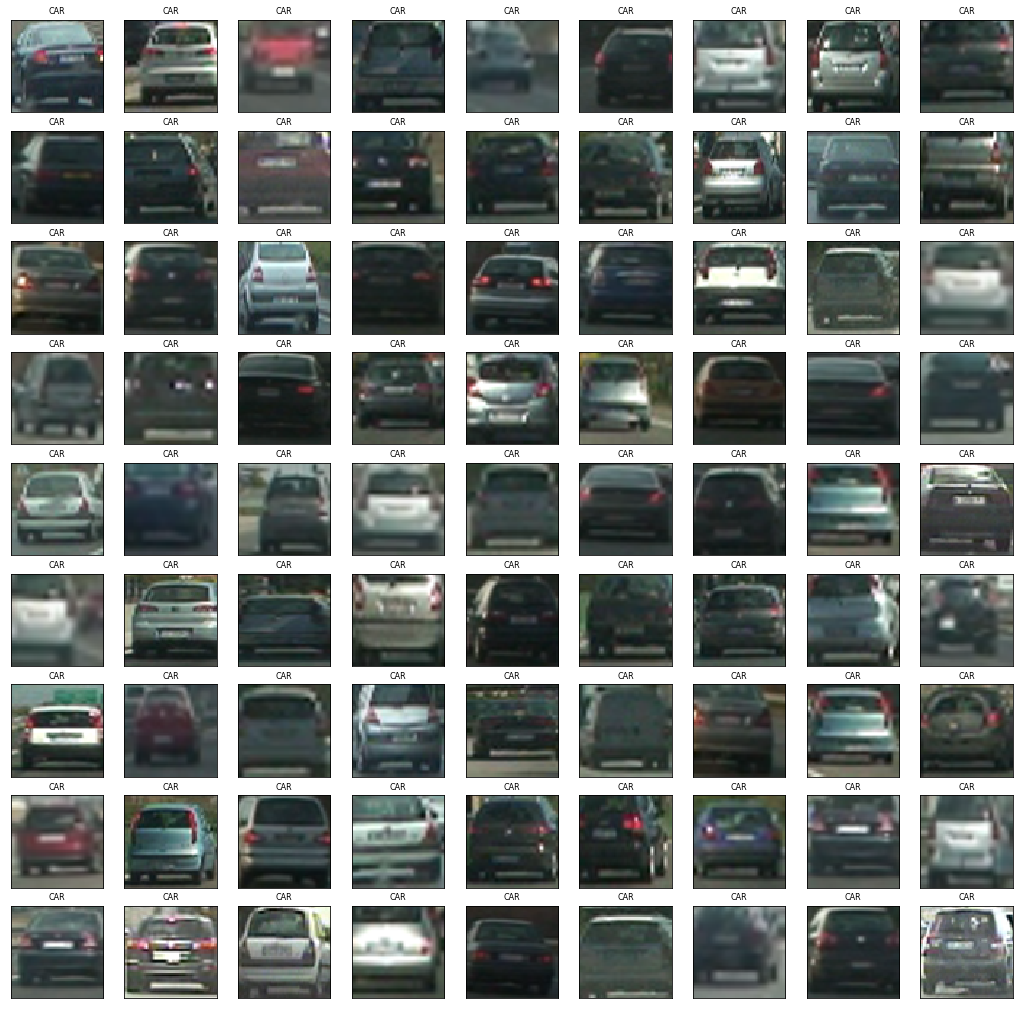

In [8]:
fig, axes = plt.subplots(9, 9, figsize=(18,18), subplot_kw={'xticks':[], 'yticks':[]})
for ax, i in zip(axes.flat, np.arange(0,81)):
    img = car_imgs[i]
    ax.imshow(img)
    ax.set_title("{}".format("CAR"), {"Fontsize":8})

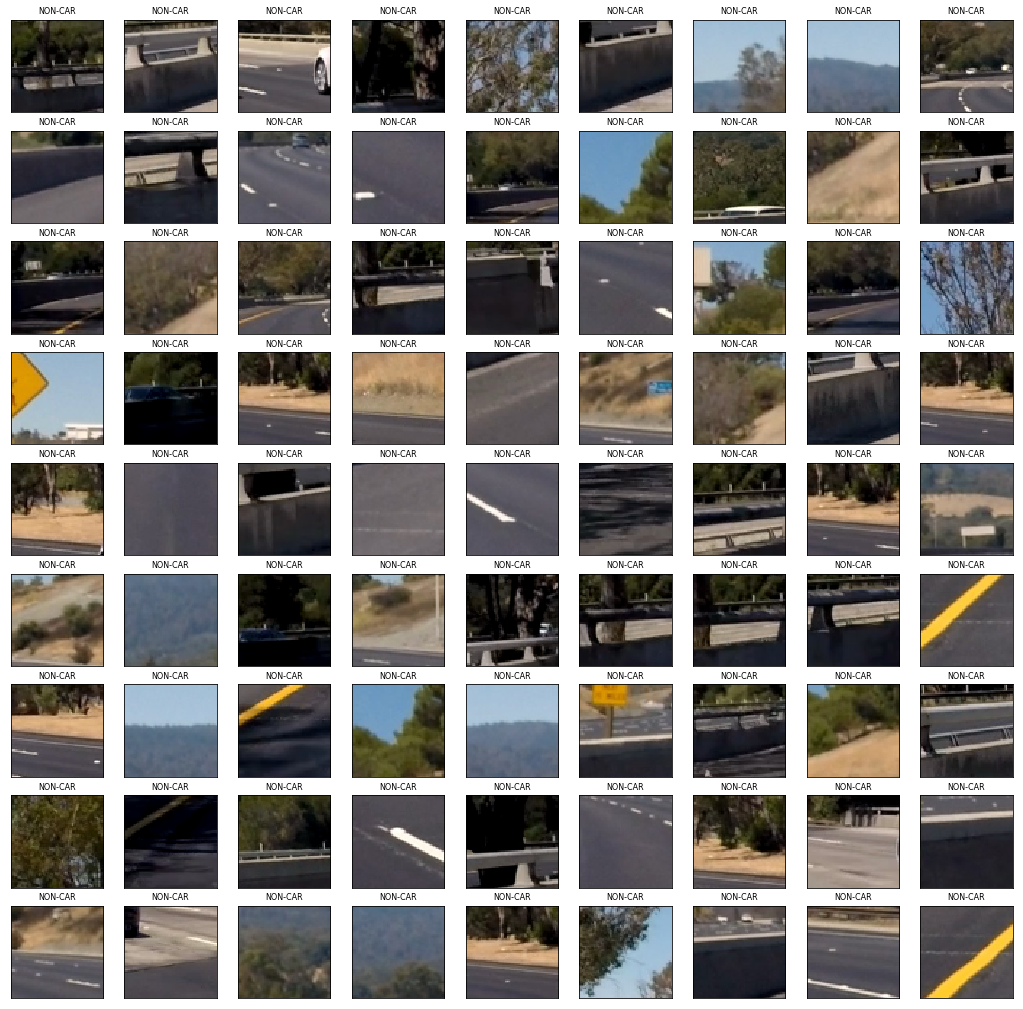

In [9]:
fig, axes = plt.subplots(9, 9, figsize=(18,18), subplot_kw={'xticks':[], 'yticks':[]})
for ax, i in zip(axes.flat, np.arange(0,81)):
    img = non_car_imgs[i]
    ax.imshow(img)
    ax.set_title("{}".format("NON-CAR"), {"Fontsize":8})

## Extract Spatial and Color Features

In [10]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Extract HOG Features

In [14]:
def get_hog_features(img, 
                     orient = 8, 
                     pix_per_cell = 8, 
                     cell_per_block = 2, 
                     vis = True,
                     feature_vec = True,
                     trans_sqrt = True):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, 
                      orientations = orient, 
                      pixels_per_cell = (pix_per_cell, pix_per_cell),            
                      cells_per_block = (cell_per_block, cell_per_block),
                      block_norm = 'L2-Hys', 
                      transform_sqrt = trans_sqrt, 
                      visualize = vis, 
                      feature_vector = feature_vec)

    if vis:
        hog_features = return_list[0]
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return return_list

## Experiment on different color space

Feature Shape:  (1568,)
Features:  [0.15405048 0.         0.         ... 0.04811838 0.25558736 0.        ]


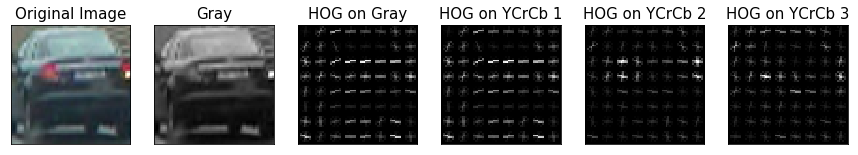

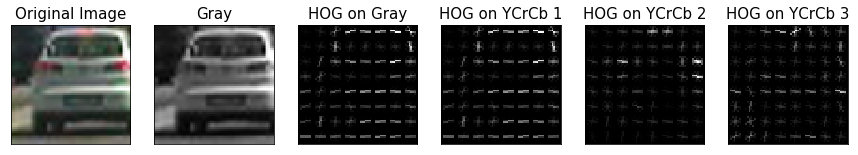

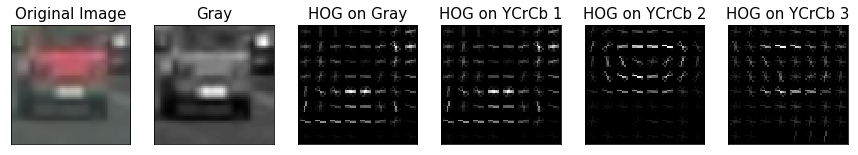

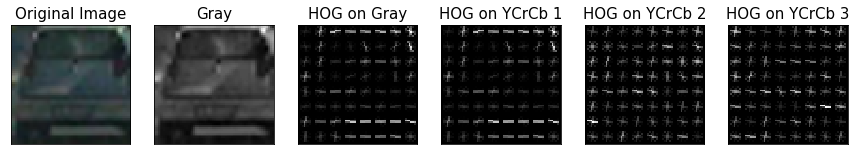

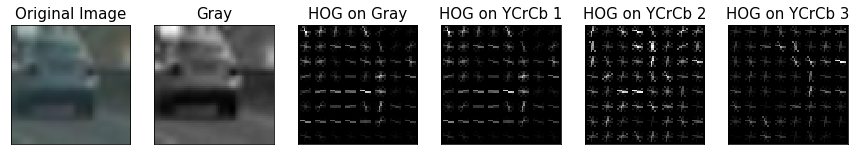

In [15]:
for i in np.arange(0, 5):
    gray_img = cv2.cvtColor(car_imgs[i], cv2.COLOR_RGB2GRAY)
    features0, hog_img = get_hog_features(gray_img)

    ycrcb1_img = cv2.cvtColor(car_imgs[i], cv2.COLOR_RGB2YCrCb)[:,:,0]
    features1, ycrcb1_hog_img = get_hog_features(ycrcb1_img)

    ycrcb2_img = cv2.cvtColor(car_imgs[i], cv2.COLOR_RGB2YCrCb)[:,:,1]
    features2, ycrcb2_hog_img = get_hog_features(ycrcb2_img)

    ycrcb3_img = cv2.cvtColor(car_imgs[i], cv2.COLOR_RGB2YCrCb)[:,:,2]
    features3, ycrcb3_hog_img = get_hog_features(ycrcb3_img)

    
    fig, axes = plt.subplots(1, 6, figsize=(15,15), subplot_kw={'xticks':[], 'yticks':[]})
    
    if i==4:
        print("Feature Shape: ", features1.shape)
        print("Features: ", features1)

    axes[0].imshow(car_imgs[i])
    axes[0].set_title('Original Image', fontsize = 15)
    axes[1].imshow(gray_img, cmap='gray')
    axes[1].set_title('Gray', fontsize = 15)
    axes[2].imshow(hog_img, cmap='gray')
    axes[2].set_title('HOG on Gray', fontsize = 15)
    axes[3].imshow(ycrcb1_hog_img, cmap='gray')
    axes[3].set_title('HOG on YCrCb 1', fontsize = 15)
    axes[4].imshow(ycrcb2_hog_img, cmap='gray')
    axes[4].set_title('HOG on YCrCb 2', fontsize = 15)
    axes[5].imshow(ycrcb3_hog_img, cmap='gray')
    axes[5].set_title('HOG on YCrCb 3', fontsize = 15)    

Feature Shape:  (1568,)
Features:  [0.30613009 0.03675142 0.12986611 ... 0.         0.16165363 0.        ]


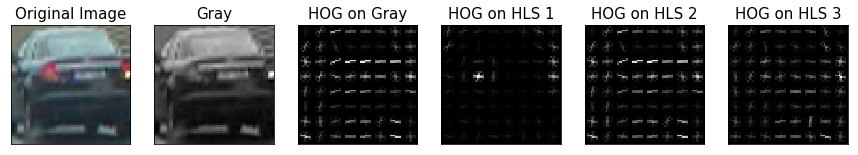

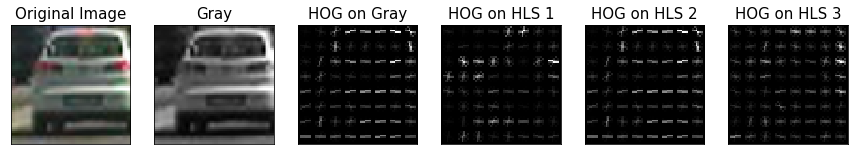

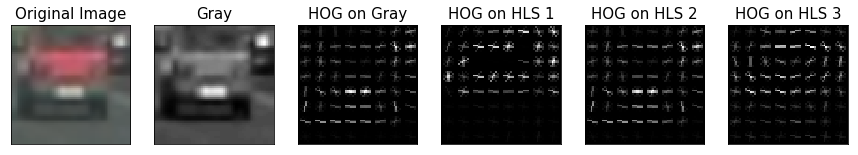

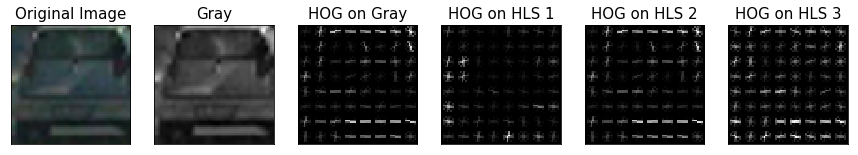

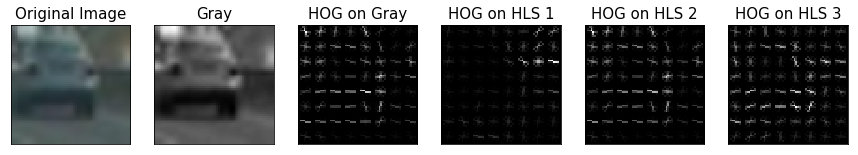

In [16]:
for i in np.arange(0, 5):
    gray_img = cv2.cvtColor(car_imgs[i], cv2.COLOR_RGB2GRAY)
    features0, hog_img = get_hog_features(gray_img)

    c1_img = cv2.cvtColor(car_imgs[i], cv2.COLOR_RGB2HLS)[:,:,0]
    features1, c1_hog_img = get_hog_features(c1_img)

    c2_img = cv2.cvtColor(car_imgs[i], cv2.COLOR_RGB2HLS)[:,:,1]
    features2, c2_hog_img = get_hog_features(c2_img)

    c3_img = cv2.cvtColor(car_imgs[i], cv2.COLOR_RGB2HLS)[:,:,2]
    features3, c3_hog_img = get_hog_features(c3_img)

    
    fig, axes = plt.subplots(1, 6, figsize=(15,15), subplot_kw={'xticks':[], 'yticks':[]})
    
    if i==4:
        print("Feature Shape: ", features1.shape)
        print("Features: ", features1)
    
    axes[0].imshow(car_imgs[i])
    axes[0].set_title('Original Image', fontsize = 15)
    axes[1].imshow(gray_img, cmap='gray')
    axes[1].set_title('Gray', fontsize = 15)
    axes[2].imshow(hog_img, cmap='gray')
    axes[2].set_title('HOG on Gray', fontsize = 15)
    axes[3].imshow(c1_hog_img, cmap='gray')
    axes[3].set_title('HOG on HLS 1', fontsize = 15)
    axes[4].imshow(c2_hog_img, cmap='gray')
    axes[4].set_title('HOG on HLS 2', fontsize = 15)
    axes[5].imshow(c3_hog_img, cmap='gray')
    axes[5].set_title('HOG on HLS 3', fontsize = 15)    

Feature Shape:  (1568,)
Features:  [0.25484579 0.18718066 0.25484579 ... 0.21966236 0.13987446 0.14357821]


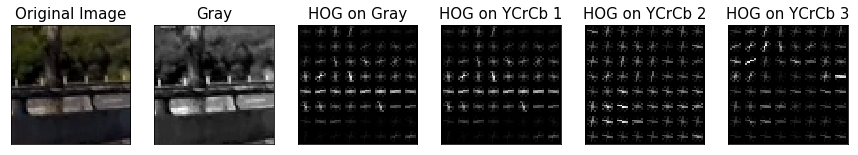

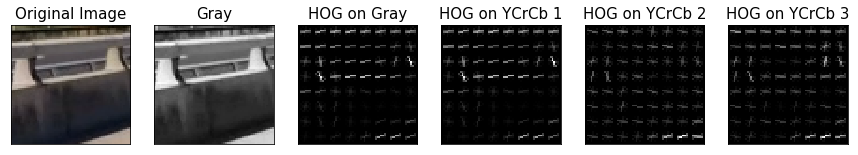

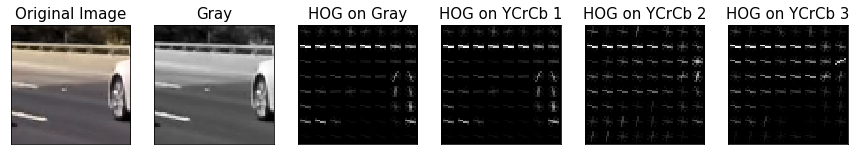

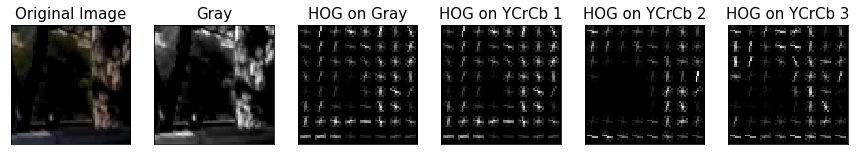

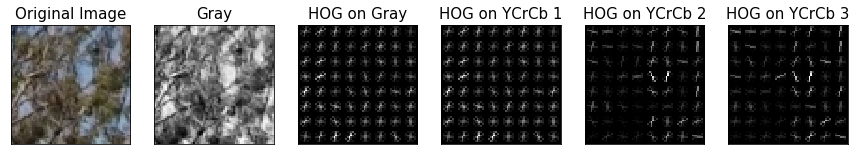

In [17]:
for i in np.arange(0, 5):
    gray_img = cv2.cvtColor(non_car_imgs[i], cv2.COLOR_RGB2GRAY)
    features0, hog_img = get_hog_features(gray_img)

    c1_img = cv2.cvtColor(non_car_imgs[i], cv2.COLOR_RGB2YCrCb)[:,:,0]
    features1, c1_hog_img = get_hog_features(c1_img)

    c2_img = cv2.cvtColor(non_car_imgs[i], cv2.COLOR_RGB2YCrCb)[:,:,1]
    features2, c2_hog_img = get_hog_features(c2_img)

    c3_img = cv2.cvtColor(non_car_imgs[i], cv2.COLOR_RGB2YCrCb)[:,:,2]
    features3, c3_hog_img = get_hog_features(c3_img)

    
    fig, axes = plt.subplots(1, 6, figsize=(15,15), subplot_kw={'xticks':[], 'yticks':[]})
    
    if i==4:
        print("Feature Shape: ", features1.shape)
        print("Features: ", features1)
    
    axes[0].imshow(non_car_imgs[i])
    axes[0].set_title('Original Image', fontsize = 15)
    axes[1].imshow(gray_img, cmap='gray')
    axes[1].set_title('Gray', fontsize = 15)
    axes[2].imshow(hog_img, cmap='gray')
    axes[2].set_title('HOG on Gray', fontsize = 15)
    axes[3].imshow(c1_hog_img, cmap='gray')
    axes[3].set_title('HOG on YCrCb 1', fontsize = 15)
    axes[4].imshow(c2_hog_img, cmap='gray')
    axes[4].set_title('HOG on YCrCb 2', fontsize = 15)
    axes[5].imshow(c3_hog_img, cmap='gray')
    axes[5].set_title('HOG on YCrCb 3', fontsize = 15)   

In [18]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, 
                     cspace = 'YCrCb',
                     orient = 9,
                     pix_per_cell = 16,
                     cell_per_block = 1,
                     hog_channel = 'ALL',
                     spatial_feat = True,
                     hist_feat = True):
                         
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        single_feature = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size = (16,16))
            single_feature.append(spatial_features)
        if hist_feat == True:
        
            hist_features = color_hist(feature_image, nbins = 32)
            single_feature.append(hist_features)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel], 
                                    orient, 
                                    pix_per_cell, 
                                    cell_per_block, 
                                    vis = False, 
                                    feature_vec = True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], 
                                            orient, 
                                            pix_per_cell, 
                                            cell_per_block, 
                                            vis = False, 
                                            feature_vec = True)
        
        # Append the new feature vector to the features list
        single_feature.append(hog_features)
        
        features.append(np.concatenate(single_feature))
    
    # Return list of feature vectors
    return features

## Training the Classifier with different hyper parameters

In [19]:
### Tweak these parameters and see how the results change.
colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t = time.time()

car_features = extract_features(car_paths, 
                                cspace = colorspace, 
                                orient = orient, 
                                pix_per_cell = pix_per_cell, 
                                cell_per_block = cell_per_block, 
                                hog_channel = hog_channel)

notcar_features = extract_features(non_car_paths, 
                                   cspace = colorspace, 
                                   orient = orient, 
                                   pix_per_cell = pix_per_cell, 
                                   cell_per_block = cell_per_block, 
                                   hog_channel = hog_channel)

t2 = time.time()

print(round(t2 - t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), 
               np.zeros(len(notcar_features))
             ))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:', orient, 'orientations', 
                pix_per_cell, 'pixels per cell and', 
                cell_per_block,'cells per block')

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2 - t, 5), 'Seconds to predict', n_predict,'labels with SVC')

98.88 Seconds to extract HOG features...
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
5.1 Seconds to train SVC...
Test Accuracy of SVC =  0.9896
My SVC predicts:  [1. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
For these 10 labels:  [1. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
0.00829 Seconds to predict 10 labels with SVC


In [20]:
### Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9
# pix_per_cell = 16
# cell_per_block = 1
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t = time.time()

car_features = extract_features(car_paths, 
                                cspace = colorspace, 
                                orient = orient, 
                                pix_per_cell = pix_per_cell, 
                                cell_per_block = cell_per_block, 
                                hog_channel = hog_channel)

notcar_features = extract_features(non_car_paths, 
                                   cspace = colorspace, 
                                   orient = orient, 
                                   pix_per_cell = pix_per_cell, 
                                   cell_per_block = cell_per_block, 
                                   hog_channel = hog_channel)

t2 = time.time()

print(round(t2 - t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), 
               np.zeros(len(notcar_features))
             ))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:', orient, 'orientations', 
                pix_per_cell, 'pixels per cell and', 
                cell_per_block,'cells per block')

print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2 - t, 5), 'Seconds to predict', n_predict,'labels with SVC')

97.88 Seconds to extract HOG features...
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
11.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9882
My SVC predicts:  [0. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
For these 10 labels:  [0. 0. 1. 0. 0. 0. 0. 1. 1. 0.]
0.0021 Seconds to predict 10 labels with SVC


## Finding The Car with Sliding Window Search

In [21]:
# Define a function that takes an:
#   image, 
#   start and stop positions in both x and y, 
#   window size (x and y dimensions), 
#   and overlap fraction (for both x and y)
def slide_window(img, 
                 x_start_stop = [None, None], 
                 y_start_stop = [None, None], 
                 xy_window = (64, 64), 
                 xy_overlap = (0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

In [22]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # Return the image copy with boxes drawn
    return imcopy

In [23]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, 
                        color_space = 'RGB', 
                        spatial_size = (32, 32),
                        hist_bins = 32, 
                        orient = 9, 
                        pix_per_cell = 8, 
                        cell_per_block = 2, 
                        hog_channel = 0,
                        spatial_feat = True, 
                        hist_feat = True, 
                        hog_feat = True): 
    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
        
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, 
                                    pix_per_cell, 
                                    cell_per_block, 
                                    vis=False, 
                                    feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                            orient, 
                                            pix_per_cell, 
                                            cell_per_block, 
                                            vis=False, 
                                            feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [24]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, 
                   windows, 
                   clf, 
                   scaler, 
                   color_space = 'RGB', 
                   spatial_size = (32, 32), 
                   hist_bins = 32, 
                   hist_range = (0, 256), 
                   orient = 9, 
                   pix_per_cell = 8, 
                   cell_per_block = 2, 
                   hog_channel = 0, 
                   spatial_feat = True, 
                   hist_feat = True, 
                   hog_feat = True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, 
                                       color_space = color_space, 
                                       spatial_size = spatial_size, 
                                       hist_bins = hist_bins, 
                                       orient = orient, 
                                       pix_per_cell = pix_per_cell, 
                                       cell_per_block = cell_per_block, 
                                       hog_channel = hog_channel, 
                                       spatial_feat = spatial_feat, 
                                       hist_feat = hist_feat, 
                                       hog_feat = hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    
    #8) Return windows for positive detections
    return on_windows

### Multi Scale Window Size

In [25]:
def multi_scale_window(image):
    x_limits = [[300, None],
                [450, None],
                [600, None]]

    y_limits = [[540, None],
                [400, 600],
                [380, 520]]

    window_size = [(128, 128),
                   (96, 96),
                   (72, 72)]

    overlap_ratio = [(0.7, 0.7),
                     (0.75, 0.75),
                     (0.8, 0.8)]
    
    all_windows = []
    
    for x_limit, y_limit, size, overlap in zip (x_limits, 
                                                y_limits, 
                                                window_size, 
                                                overlap_ratio):
        windows = slide_window(
            image,
            x_start_stop = x_limit,
            y_start_stop = y_limit, 
            xy_window = size,
            xy_overlap = overlap
        )
        all_windows.extend(windows)
    
    return all_windows

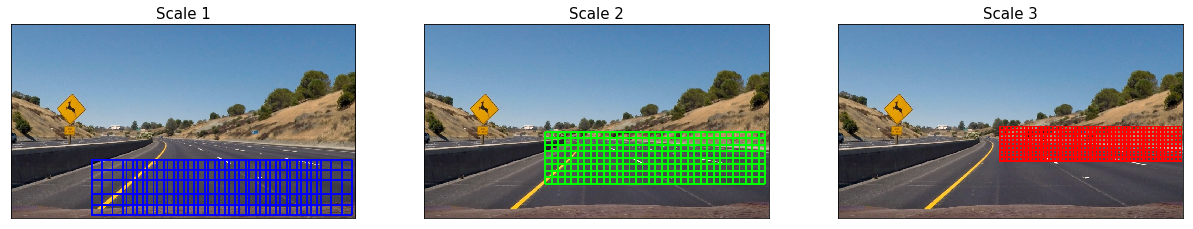

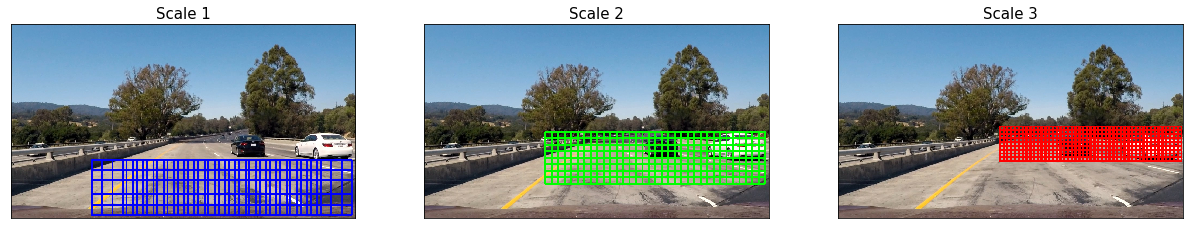

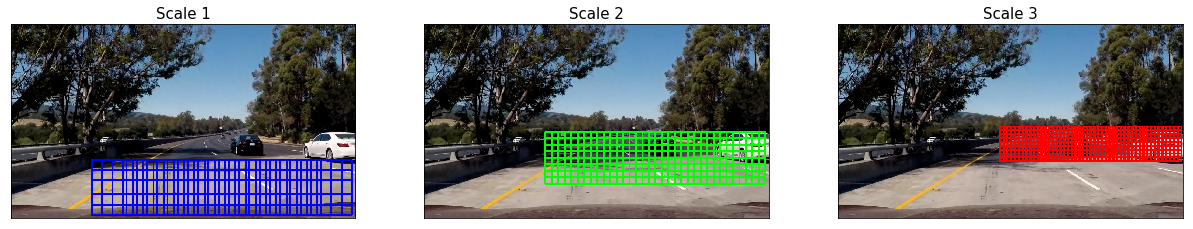

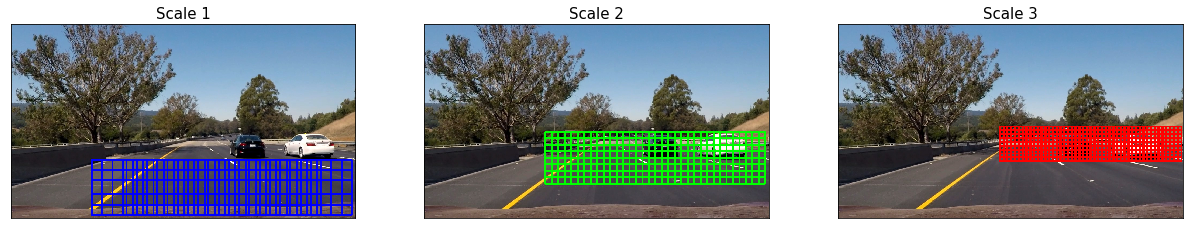

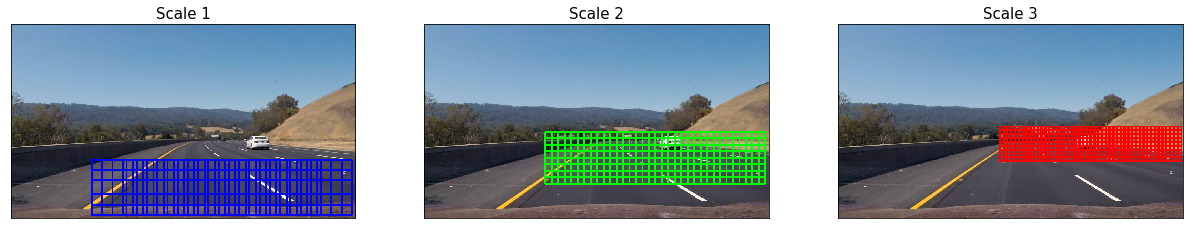

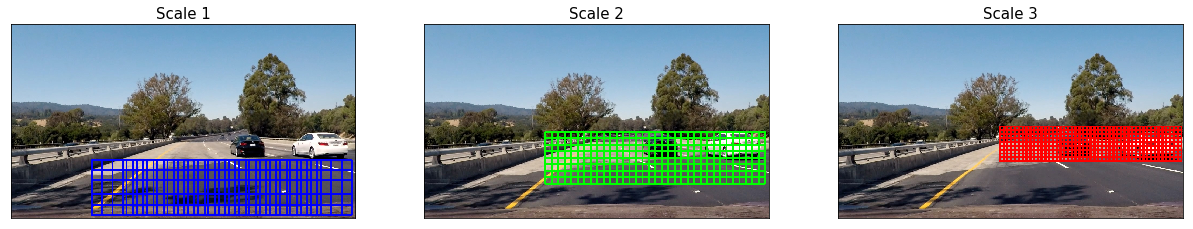

In [26]:
test_imgs_path = 'test_images/*.jpg'
test_imgs_list = glob.glob(test_imgs_path)

for test_img in test_imgs_list:
    
    image = mpimg.imread(test_img)
    draw_image = np.copy(image)

    
    # Big
    windows1 = slide_window(image,
                           x_start_stop = [300, None],
                           y_start_stop = [504, None],
                           xy_window = [128, 128],
                           xy_overlap = [0.7, 0.7])

    empty_window_img1 = draw_boxes(draw_image, windows1, color=(0, 0, 255), thick = 6)    
    
    
    # Medium
    windows2 = slide_window(image,
                           x_start_stop = [450, None],
                           y_start_stop = [400, 600],
                           xy_window = [96, 96],
                           xy_overlap = [0.75, 0.75])

    empty_window_img2 = draw_boxes(draw_image, windows2, color=(0, 255, 0), thick = 6)  
        
    # Small
    windows3 = slide_window(image,
                           x_start_stop = [600, None],
                           y_start_stop = [380, 520],
                           xy_window = [72, 72],
                           xy_overlap = [0.8, 0.8])

    empty_window_img3 = draw_boxes(draw_image, windows3, color=(255, 0, 0), thick = 6)  

    fig, axes = plt.subplots(1, 3, figsize=(21,7), subplot_kw={'xticks':[], 'yticks':[]})
        
    axes[0].imshow(empty_window_img1)
    axes[0].set_title('Scale 1', fontsize = 15)
    axes[1].imshow(empty_window_img2)
    axes[1].set_title('Scale 2', fontsize = 15)
    axes[2].imshow(empty_window_img3)
    axes[2].set_title('Scale 3', fontsize = 15)

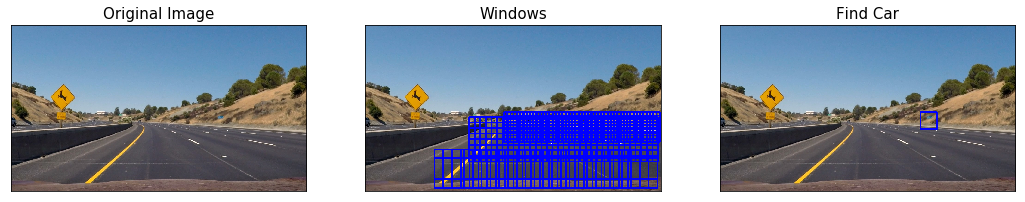

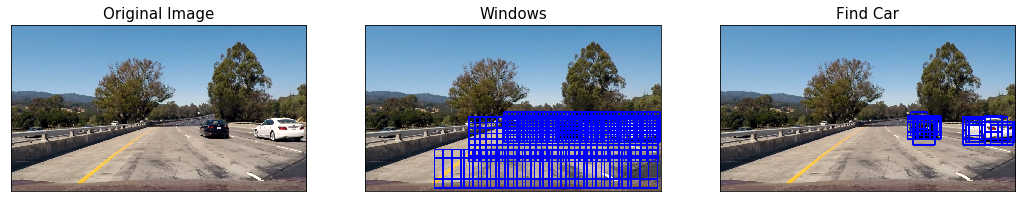

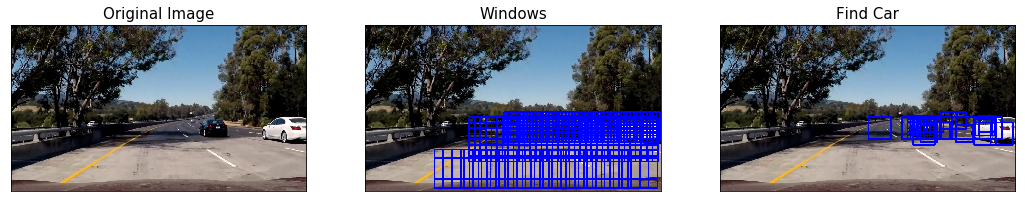

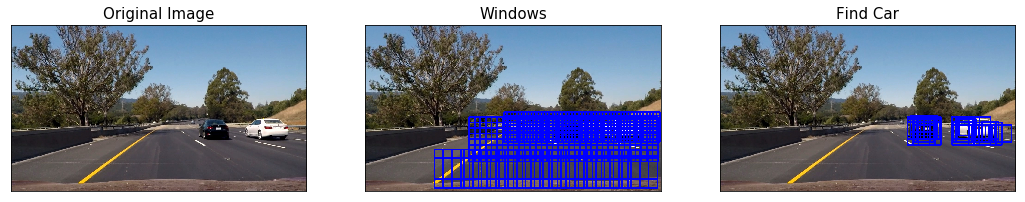

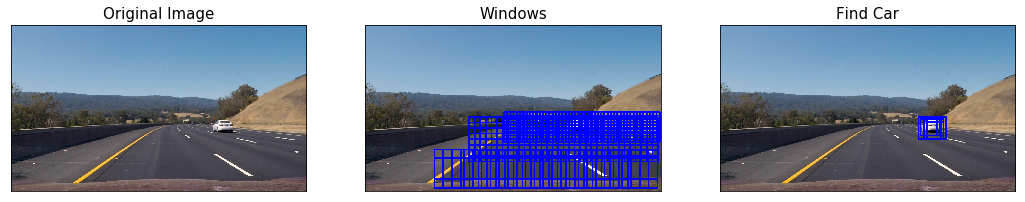

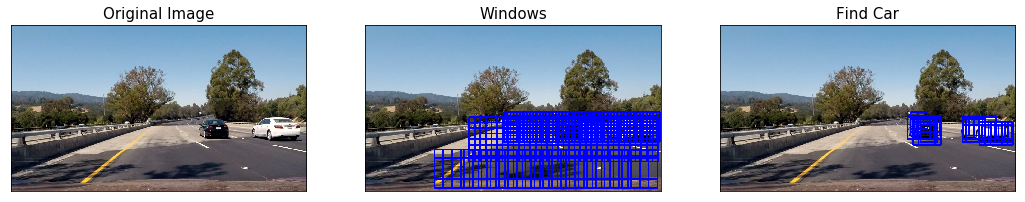

In [27]:
test_imgs_path = 'test_images/*.jpg'
test_imgs_list = glob.glob(test_imgs_path)

for test_img in test_imgs_list:
    
    image = mpimg.imread(test_img)
    draw_image = np.copy(image)
    image = image.astype(np.float32) / 255
    
    windows = multi_scale_window(image)

    empty_window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick = 6)    
    
    hot_windows = search_windows(image, 
                                 windows, 
                                 svc, 
                                 X_scaler, 
                                 color_space = 'YCrCb', 
                                 spatial_size = (16, 16), 
                                 hist_bins = 32, 
                                 orient = 8, 
                                 pix_per_cell = 8, 
                                 cell_per_block = 2, 
                                 hog_channel = 'ALL', 
                                 spatial_feat = True, 
                                 hist_feat = True, 
                                 hog_feat = True)    

    hot_window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick = 6)                    

    fig, axes = plt.subplots(1, 3, figsize=(18,6), subplot_kw={'xticks':[], 'yticks':[]})
        
    axes[0].imshow(draw_image)
    axes[0].set_title('Original Image', fontsize = 15)
    axes[1].imshow(empty_window_img)
    axes[1].set_title('Windows', fontsize = 15)
    axes[2].imshow(hot_window_img)
    axes[2].set_title('Find Car', fontsize = 15)
    

## Multiple Detection and False Positives

In [35]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 10)
    # Return the image
    return img

In [29]:
def heat_threshold(img, threshold, windows_list):

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,windows_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

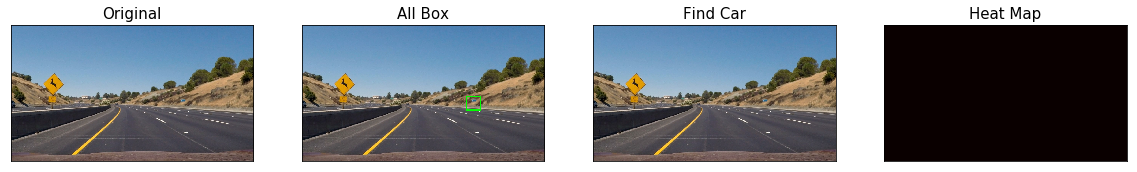

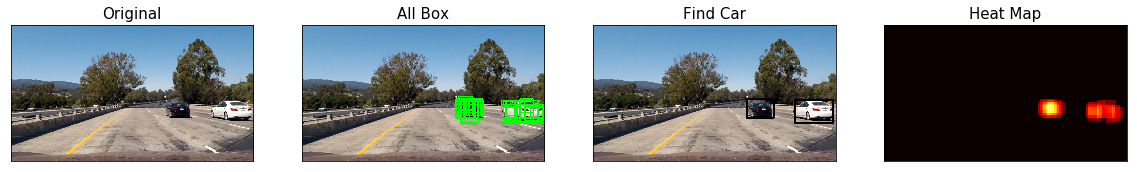

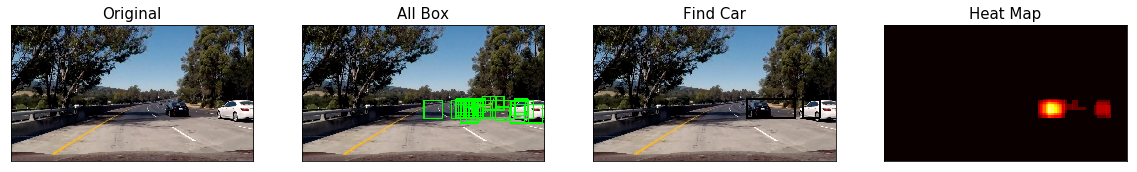

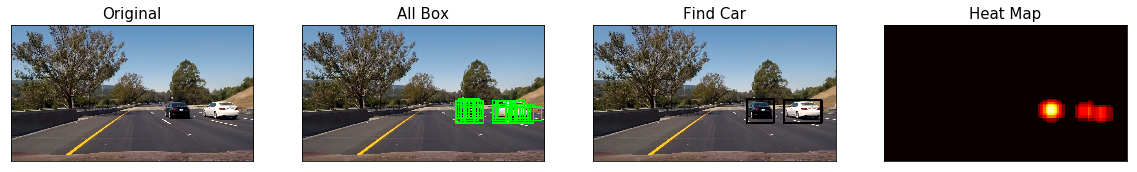

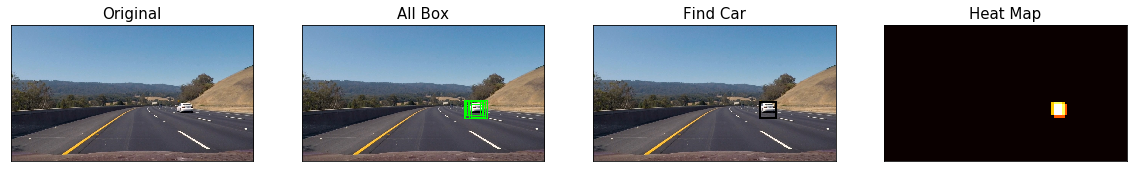

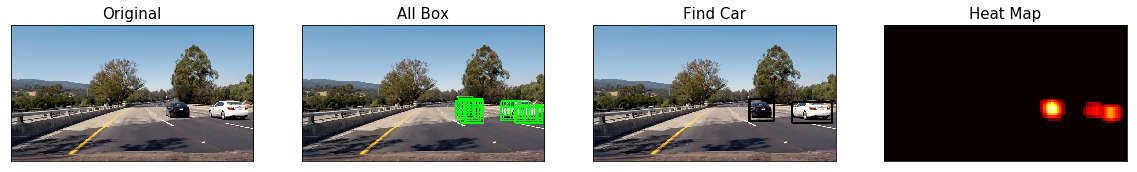

In [36]:
test_imgs_path = 'test_images/*.jpg'
test_imgs_list = glob.glob(test_imgs_path)

for test_img in test_imgs_list:
    image = mpimg.imread(test_img)
    
    copy_img = np.copy(image)
    
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    
    #box_list = fast_find_car(image)
    

    image = image.astype(np.float32) / 255
    windows = multi_scale_window(copy_img)
    box_list = search_windows(image, 
                                 windows, 
                                 svc, 
                                 X_scaler, 
                                 color_space = 'YCrCb', 
                                 spatial_size = (16, 16), 
                                 hist_bins = 32, 
                                 orient = 8, 
                                 pix_per_cell = 8, 
                                 cell_per_block = 2, 
                                 hog_channel = 'ALL', 
                                 spatial_feat = True, 
                                 hist_feat = True, 
                                 hog_feat = True) 
    
    all_box_img = draw_boxes(copy_img, box_list, color=(0, 255, 0), thick = 6)  

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    threshold = 2
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)               

    fig, axes = plt.subplots(1, 4, figsize=(20,5), subplot_kw={'xticks':[], 'yticks':[]})
        

    axes[0].imshow(image)
    axes[0].set_title('Original', fontsize = 15)
    axes[1].imshow(all_box_img)
    axes[1].set_title('All Box', fontsize = 15)
    axes[2].imshow(draw_img)
    axes[2].set_title('Find Car', fontsize = 15)
    axes[3].imshow(heatmap, cmap='hot')
    axes[3].set_title('Heat Map', fontsize = 15)


## Generate Video

In [31]:
def process_image(input_img):
    image = input_img.astype(np.float32) / 255
    windows = multi_scale_window(input_img)
    box_list = search_windows(image, 
                                 windows, 
                                 svc, 
                                 X_scaler, 
                                 color_space = 'YCrCb', 
                                 spatial_size = (16, 16), 
                                 hist_bins = 32, 
                                 orient = 8, 
                                 pix_per_cell = 8, 
                                 cell_per_block = 2, 
                                 hog_channel = 'ALL', 
                                 spatial_feat = True, 
                                 hist_feat = True, 
                                 hog_feat = True)        
    threshold = 4
    draw_img = heat_threshold(input_img, threshold, box_list)
    return draw_img

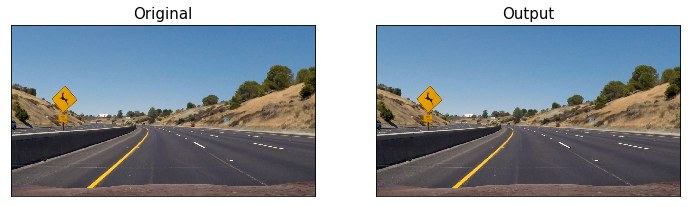

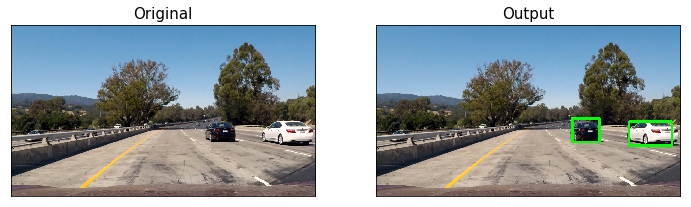

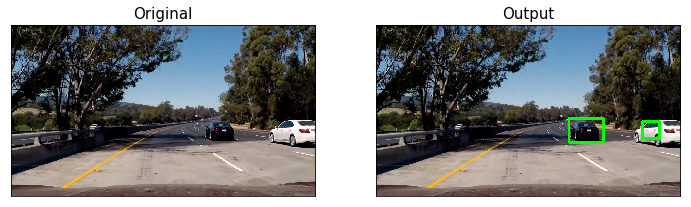

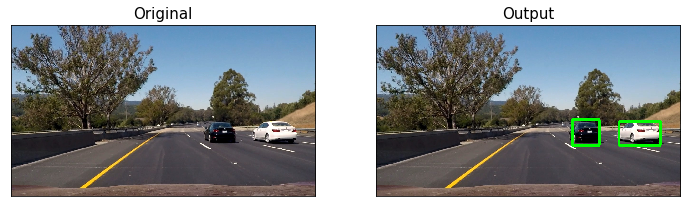

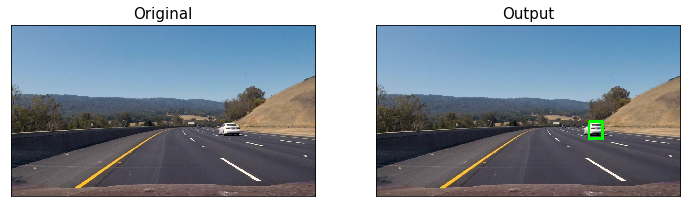

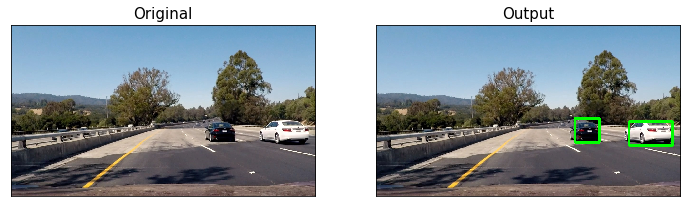

In [32]:
test_imgs_path = 'test_images/*.jpg'
test_imgs_list = glob.glob(test_imgs_path)

for test_img in test_imgs_list:
    image = mpimg.imread(test_img)
    
    out_img = process_image(image)

    fig, axes = plt.subplots(1, 2, figsize=(12,6), subplot_kw={'xticks':[], 'yticks':[]})

    axes[0].imshow(image)
    axes[0].set_title('Original', fontsize = 15)
    axes[1].imshow(out_img)
    axes[1].set_title('Output', fontsize = 15)

In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [49:32<00:02,  2.36s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 49min 29s, sys: 2.87 s, total: 49min 32s
Wall time: 49min 33s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Integration with Advanced Lane Line Detection

In [40]:
def find_object_image_sets(path_str, nx, ny, show_img=False):
    object_sets = []
    image_sets = []
    
    # Generate a matrics, have nx * ny rows, 3 colomns, type is np.float32
    object_points = np.zeros((nx * ny, 3), np.float32)
    object_points[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    # Load all chessboard images path
    chessboard_imgs_path = glob.glob(path_str)

    for chessboard_img_path in chessboard_imgs_path:
        # Load image
        img = cv2.imread(chessboard_img_path)
        
        # Convert into grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if ret == True:
            object_sets.append(object_points)
            image_sets.append(corners)
            
            # Draw the corners on the chessboard
            if show_img == True:
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                f, ax = plt.subplots(1, 1, figsize=(7, 7))
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(chessboard_img_path, fontsize = 20)
                
    size = (mpimg.imread(chessboard_imgs_path[0]).shape[1], mpimg.imread(chessboard_imgs_path[0]).shape[0])

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_sets, image_sets, size, None, None)
    return (mtx, dist)

In [41]:
chessboard_imgs_path = "./camera_cal/*.jpg"

nx = 9 # The number of inside corners in x
ny = 6 # The number of inside corners in y

calibration_matrix, distortion_coefficients = find_object_image_sets(chessboard_imgs_path, nx, ny, False)

In [42]:
def undistort_image(image, calibration_matrix, distortion_coefficients):
    undistorted_image = cv2.undistort(image, calibration_matrix, distortion_coefficients, None, calibration_matrix)
    return undistorted_image

In [43]:
# The function that thresholds the L-channel of LUV
def l_channel_LUV(img, thresh=(0, 255)):
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    l_channel = luv[:,:,0]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

In [44]:
# The function that thresholds the L & B channel of LAB
def lb_channel_LAB(img, lthresh=(0, 255), bthresh=(0,255)):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel = lab[:,:,0]
    b_channel = lab[:,:,2]
    l_binary_output = np.zeros_like(l_channel)
    l_binary_output[(l_channel > lthresh[0]) & (l_channel <= lthresh[1])] = 1
    b_binary_output = np.zeros_like(b_channel)
    b_binary_output[(b_channel > bthresh[0]) & (b_channel <= bthresh[1])] = 1
    combined_binary = np.zeros_like(b_channel)
    combined_binary[(l_binary_output == 1) | (b_binary_output == 1)] = 1
    return combined_binary

In [45]:
def color_thresholding(img):
    # I finally didn't use HLS, since it has more noise
    luv_binary = l_channel_LUV(img, thresh=(210, 255))
    lab_binary = lb_channel_LAB(img, lthresh=(230, 255), bthresh=(155,255))
    combined_binary = np.zeros_like(lab_binary)
    combined_binary[(luv_binary == 1) | (lab_binary == 1)] = 1
    return combined_binary

In [46]:
# The function that takes an image, gradient orientation, and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [47]:
# The function to return the magnitude of the gradient for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [48]:
# The function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [49]:
def gradient_threshold(img, ksize=15, sthresh=(20, 100), mthresh =(20, 100), dthresh=(0.7, 1.3)):
    gradx = abs_sobel_thresh(img, orient='x', thresh=sthresh)
    grady = abs_sobel_thresh(img, orient='y', thresh=sthresh)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=mthresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=dthresh)
    
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined_binary

In [61]:
height = 720
length = 1280
left_down = (230, height - 25)
left_top = (560, 410)
right_top = (700, 410)
right_down = (length - 90, height - 25)
trapezoid_outter = np.array([[left_down, left_top, right_top, right_down]])

left_down = (370, height - 25)
left_top = (600, 480)
right_top = (680, 480)
right_down = (length - 240, height - 25)
trapezoid_inner = np.array([[left_down, left_top, right_top, right_down]])

In [62]:
def region_of_interest(img, vertices_out, vertices_in):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
            
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices_out, 1)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    cv2.fillPoly(masked_image, vertices_in, 0)
    return masked_image

In [63]:
def thresholding_with_mask(img, trapezoid_out, trapezoid_in):
    color_thresh = color_thresholding(img)
    gradient_thresh = gradient_threshold(img)
    
    combined_binary = np.zeros_like(gradient_thresh)
    combined_binary[(color_thresh == 1) | (gradient_thresh == 1)] = 1
    
    after_mask = region_of_interest(combined_binary, trapezoid_out, trapezoid_in)
    return after_mask

In [72]:
def calculate_M_Minv():    
    height = 720
    length = 1280
    
    # Four source coordinates
    src = np.float32([
        [210,height],
        [595,450],
        [690,450], 
        [1110, height]
    ])
    
    # Four desired coordinates
    dst = np.float32([
        [200, height], 
        [200, 0], 
        [1000, 0], 
        [1000, height]
    ])
    
    # Compute the perspective transform matrix, M
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

M, Minv = calculate_M_Minv()

In [73]:
def warp(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

In [74]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,
                      (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high),
                      (0, 255,0), 
                      8) 
        cv2.rectangle(out_img,
                      (win_xright_low, win_y_low),
                      (win_xright_high, win_y_high),
                      (0, 255, 0), 
                      8) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  
                          (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & 
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  
                           (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [255, 0, 0]

    return out_img, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty

In [75]:
def measure_curvature_real(leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 720
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
    radius = (left_curverad + right_curverad) / 2
    offset = (640 - (leftx[-1] + rightx[-1]) / 2) * xm_per_pix
    
    return radius, offset

In [76]:
def draw_lines(undist, warped, left_fitx, right_fitx, ploty, Minv):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 102, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.7, 0)
    
    return result

In [77]:
def add_text(img, radius, offset):
    cv2.putText(img, 
                'Radius of curvature of the lane: {}(m)'.format(round(radius, 3)), 
                (500, 20 * 3),
                fontFace = 16, 
                fontScale = 1, 
                color=(255, 255, 255), 
                thickness = 2) 
    cv2.putText(img, 
                'Offset from center: {}(m)'.format(round(offset, 3)), 
                (500, 20 * 5),
                fontFace = 16, 
                fontScale = 1, 
                color=(255, 255, 255), 
                thickness = 2) 
    return img

In [78]:
def process_image1(image1):
    image2 = undistort_image(image1, calibration_matrix, distortion_coefficients)
    image3 = thresholding_with_mask(image2, trapezoid_outter, trapezoid_inner)
    image4 = after_perspective_trans = warp(image3, M)
    image41 = warp(image2, M)
    image5, left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty = fit_polynomial(image4.astype(np.uint8))
    radius, offset = measure_curvature_real(leftx, lefty, rightx, righty)
    image6 = draw_lines(image2, image4, left_fitx, right_fitx, ploty, Minv)
    small_1 = cv2.resize(image5, (int(image5.shape[1] / 4), int(image5.shape[0] / 4)))
    x_offset_1 = 30
    y_offset_1 = 30
    result = add_text(image6, radius, offset)
    result[y_offset_1 : y_offset_1 + small_1.shape[0], x_offset_1 : x_offset_1 + small_1.shape[1]] = small_1
    small_2 = cv2.resize(image41, (int(image41.shape[1] / 4), int(image41.shape[0] / 4)))
    x_offset_2 = 30
    y_offset_2 = 60 + small_1.shape[0]
    result[y_offset_2 : y_offset_2 + small_2.shape[0], x_offset_2 : x_offset_2 + small_2.shape[1]] = small_2
    return result

In [79]:
def process_image2(input_img):
    img_copy = np.copy(input_img)
    
    adv_img = process_image1(img_copy)
    
    image = input_img.astype(np.float32) / 255
    windows = multi_scale_window(input_img)
    box_list = search_windows(image, 
                                 windows, 
                                 svc, 
                                 X_scaler, 
                                 color_space = 'YCrCb', 
                                 spatial_size = (16, 16), 
                                 hist_bins = 32, 
                                 orient = 8, 
                                 pix_per_cell = 8, 
                                 cell_per_block = 2, 
                                 hog_channel = 'ALL', 
                                 spatial_feat = True, 
                                 hist_feat = True, 
                                 hog_feat = True)        
    
    threshold = 4
    draw_img = heat_threshold(adv_img, threshold, box_list)
    return draw_img

In [84]:
white_output2 = 'project_video_output2.mp4'
clip2 = VideoFileClip("project_video.mp4")
white_clip2 = clip2.fl_image(process_image2)
%time white_clip2.write_videofile(white_output2, audio=False)

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████▉| 1260/1261 [56:08<00:02,  2.67s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

CPU times: user 1h 10min 29s, sys: 18.8 s, total: 1h 10min 48s
Wall time: 56min 8s


In [85]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output2))

## HOG Sub-Sampling Windows Search Reduce Overlapping Computation

In [ ]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, 
              ystart, 
              ystop,
              xstart,
              xstop,
              scale, 
              svc, 
              X_scaler, 
              orient, 
              pix_per_cell, 
              cell_per_block, 
              spatial_size, 
              hist_bins,
              window = 64,
              cells_per_step = 2,
              vis = False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    #nfeat_per_block = orient * cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    #window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False, vis=False)
    
    
    car_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop : ytop + window, xleft : xleft + window], (64, 64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size = spatial_size)
            hist_features = color_hist(subimg, nbins = hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_features = X_scaler.transform(np.array(hog_features).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                if vis == True:
                    cv2.rectangle(draw_img,
                                  (xbox_left + xstart, ytop_draw + ystart),
                                  (xbox_left + win_draw + xstart, ytop_draw + win_draw + ystart),
                                  (0, 255, 0), 6)
                else:
                    car_windows.append(((xbox_left + xstart, ytop_draw + ystart),
                                        (xbox_left + win_draw + xstart, ytop_draw + win_draw + ystart)))
    if vis == True:
        return draw_img
    else:
        return car_windows

In [ ]:
test_imgs_path = 'test_images/*.jpg'
test_imgs_list = glob.glob(test_imgs_path)

for test_img in test_imgs_list:
    
    image = mpimg.imread(test_img)
    draw_image = np.copy(image)

    ystart = 320
    ystop = 656
    xstart = 600
    xstop = 1280
    
    scale = 1.2
    out_img1 = find_cars(draw_image, 
                        ystart, 
                        ystop, 
                        xstart,
                        xstop,
                        scale,
                        svc,
                        X_scaler, 
                        orient = 8,
                        pix_per_cell = 8, 
                        cell_per_block = 2, 
                        spatial_size = (16, 16),
                        hist_bins = 32,
                        window = 64,
                        cells_per_step = 1,
                        vis = True)    
    
    scale = 1.5
    out_img2 = find_cars(draw_image, 
                        ystart, 
                        ystop, 
                        xstart,
                        xstop,
                        scale,
                        svc,
                        X_scaler, 
                        orient = 8,
                        pix_per_cell = 8, 
                        cell_per_block = 2, 
                        spatial_size = (16, 16),
                        hist_bins = 32,
                        window = 64,
                        cells_per_step = 1,
                        vis = True)

    scale = 2.0
    out_img3 = find_cars(draw_image, 
                        ystart, 
                        ystop, 
                        xstart,
                        xstop,
                        scale, 
                        svc, 
                        X_scaler, 
                        orient = 8,
                        pix_per_cell = 8, 
                        cell_per_block = 2, 
                        spatial_size = (16, 16),
                        hist_bins = 32,
                        window = 64,
                        cells_per_step = 1,
                        vis = True)

    scale = 2.0
    out_img4 = find_cars(draw_image, 
                        ystart, 
                        ystop, 
                        xstart,
                        xstop,
                        scale, 
                        svc, 
                        X_scaler, 
                        orient = 8,
                        pix_per_cell = 8, 
                        cell_per_block = 2, 
                        spatial_size = (16, 16),
                        hist_bins = 32,
                        window = 64,
                        cells_per_step = 1,
                        vis = True)

    fig, axes = plt.subplots(1, 4, figsize=(20,5), subplot_kw={'xticks':[], 'yticks':[]})
        

    axes[0].imshow(out_img1)
    axes[0].set_title('Find Car Scale=1.2', fontsize = 15)
    axes[1].imshow(out_img2)
    axes[1].set_title('Find Car Scale=1.5', fontsize = 15)
    axes[2].imshow(out_img3)
    axes[2].set_title('Find Car Scale=2.0', fontsize = 15)
    axes[3].imshow(out_img4)
    axes[3].set_title('Find Car Scale=2.5', fontsize = 15)

In [ ]:
def fast_find_car(img):

    ystart = 320
    ystop = 656
    xstart = 600
    xstop = 1280
    
    scale = 1.2
    boxes1 = find_cars(image, 
                        ystart, 
                        ystop, 
                        xstart,
                        xstop,
                        scale,
                        svc,
                        X_scaler, 
                        orient = 9,
                        pix_per_cell = 16, 
                        cell_per_block = 1, 
                        spatial_size = 0,
                        hist_bins = 0,
                        window = 64,
                        cells_per_step = 1,
                        vis = False)    
    
    scale = 1.5
    boxes2 = find_cars(image, 
                        ystart, 
                        ystop, 
                        xstart,
                        xstop,
                        scale,
                        svc,
                        X_scaler, 
                        orient = 9,
                        pix_per_cell = 16, 
                        cell_per_block = 1, 
                        spatial_size = 0,
                        hist_bins = 0,
                        window = 64,
                        cells_per_step = 1,
                        vis = False)

    scale = 2.0
    boxes3 = find_cars(image, 
                        ystart, 
                        ystop, 
                        xstart,
                        xstop,
                        scale, 
                        svc, 
                        X_scaler, 
                        orient = 9,
                        pix_per_cell = 16, 
                        cell_per_block = 1, 
                        spatial_size = 0,
                        hist_bins = 0,
                        window = 64,
                        cells_per_step = 1,
                        vis = False)

    scale = 2.5
    boxes4 = find_cars(image, 
                        ystart, 
                        ystop, 
                        xstart,
                        xstop,
                        scale, 
                        svc, 
                        X_scaler, 
                        orient = 9,
                        pix_per_cell = 16, 
                        cell_per_block = 1, 
                        spatial_size = 0,
                        hist_bins = 0,
                        window = 64,
                        cells_per_step = 1,
                        vis = False)
    
    all_boxes = boxes1 + boxes2 + boxes3 + boxes4
    
    return all_boxes

In [ ]:
test_img1 = 'test_images/test3.jpg'
image1 = mpimg.imread(test_img1)
fast_find_car(image1)